# Import Redlining Data

## get Aarronson replication data to work from https://www.aeaweb.org/articles?id=10.1257/pol.20190414

In [3]:
import os
import geopandas as gpd
import pandas as pd

# Fix PROJ path if needed (for coordinate transforms)
os.environ["PROJ_LIB"] = "/home/idies/mambaforge/envs/econark/share/proj"

# === 1. Load HOLC data ===
holc = gpd.read_file("mappinginequality.gpkg")

# === 2. Filter for Chicago ===
holc_chi = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
print(f"HOLC polygons loaded for Chicago: {len(holc_chi)}")

# Keep relevant columns
holc_chi = holc_chi[["area_id", "grade", "geometry"]]

# Display a preview table
display(holc_chi.head())

# === 3. Ensure coordinate system is projected in meters ===
# This step is required for buffer distances
holc_chi = holc_chi.to_crs(epsg=26916)  # NAD83 / UTM zone 16N (covers Chicago region)

# === 4. Create 0.25-mile (≈402 meters) buffers around each HOLC boundary ===
buffer_distance = 402  # meters
holc_buffers = holc_chi.copy()
holc_buffers["geometry"] = holc_buffers.buffer(buffer_distance)

print(f"Created buffer zones of {buffer_distance} meters around each HOLC area.")

# Preview buffers (optional)
display(holc_buffers.head())

# === 5. (Optional) Save buffers for reference ===
holc_buffers.to_file("holc_chicago_buffers.geojson", driver="GeoJSON")


HOLC polygons loaded for Chicago: 703


,area_id,grade,geometry
2014,11474,C,"POLYGON ((-87.86999 41.8197, -87.87006 41.8233..."
2015,1065,A,"MULTIPOLYGON (((-87.83054 42.25361, -87.82979 ..."
2016,1091,A,"MULTIPOLYGON (((-87.76217 42.12934, -87.76233 ..."
2017,1097,A,"MULTIPOLYGON (((-87.75082 42.13867, -87.75053 ..."
2018,1098,A,"MULTIPOLYGON (((-87.74436 42.12695, -87.74135 ..."


Created buffer zones of 402 meters around each HOLC area.


,area_id,grade,geometry
2014,11474,C,"POLYGON ((426501.158 4631102.289, 426501.124 4..."
2015,1065,A,"POLYGON ((430989.125 4678536.198, 430972.686 4..."
2016,1091,A,"POLYGON ((436050.786 4664575.527, 436017.29 46..."
2017,1097,A,"POLYGON ((437691.157 4665139.636, 437664.449 4..."
2018,1098,A,"POLYGON ((437876.08 4664646.724, 437715.346 46..."


# Table 1
- There are 703 mapped areas (neighborhood polygons) in Chicago that were graded by the Home Owners’ Loan Corporation (HOLC) in the 1930s.
- Each of these polygons corresponds to a distinct neighborhood “area” on the redlining map.

# Table 2
- created 0.25-mile buffer polygons (≈402 meters) around each HOLC area.
- The geometry numbers are now in meters, not degrees**,** because we switched to a projected coordinate system — this allows accurate measurement of distances like “0.25 miles.”

# Import School Data

In [8]:
import pandas as pd

# === 1. Load both files ===
locations = pd.read_csv("school-locations.csv", dtype=str)
school_info = pd.read_csv("school-level.csv", dtype=str)

# === 2. Merge on NCESSCH (the unique school code) ===
merged = locations.merge(school_info, on="NCESSCH", how="inner")

# === 3. Filter for Chicago high schools ===
# Check column names that describe school type (they vary by dataset)
# Common ones include "LEVEL", "SCH_LEVEL", or "SCHOOL_TYPE"
# You can inspect available columns with:
# print(merged.columns)

# Example: assuming the column indicating school level is "LEVEL"
# and that high schools are labeled "High" or contain the word "High"
merged_chi = merged[
    (merged["CITY"].str.contains("Chicago", case=False, na=False)) &
    (merged["SCH_TYPE"].str.contains("1", case=False, na=False))
].copy()

# === 4. Keep relevant columns ===
cols_to_keep = ["NCESSCH", "NAME", "LAT", "LON", "CITY", "STATE"]
merged_chi = merged_chi[cols_to_keep]

# === 5. Convert coordinates to numeric (for mapping / GeoDataFrame use later) ===
merged_chi["LAT"] = merged_chi["LAT"].astype(float)
merged_chi["LON"] = merged_chi["LON"].astype(float)


# === 6. Display the resulting table ===
print("\n=== Chicago High Schools with Coordinates ===")
print(merged_chi.head(20).to_string(index=False))

# === 7. (Optional) Save to CSV for use in GIS or later analysis ===
merged_chi.to_csv("chicago_high_schools_with_coords.csv", index=False)


=== Chicago High Schools with Coordinates ===
     NCESSCH                              NAME       LAT        LON            CITY STATE
170011004813         Neal Math Science Academy 42.324000 -87.855350   North Chicago    IL
170011004814           A J Katzenmaier Academy 42.326049 -87.862726   North Chicago    IL
170011004815           Evelyn Alexander School 42.337313 -87.840019   North Chicago    IL
170011005370  North Chicago Community High Sch 42.328032 -87.853182   North Chicago    IL
170011006357  Green Bay Early Childhood Center 42.320900 -87.868603   North Chicago    IL
170011006401           LEARN 10 Charter School 42.315417 -87.853826   North Chicago    IL
170141006254  Horizon Science Acad-McKinley Pk 41.822594 -87.682103         Chicago    IL
170141206309      Horizon Science Acad-Belmont 41.925459 -87.770026         Chicago    IL
170142406394 Betty Shabazz Internl Charter Sch 41.752403 -87.599982         Chicago    IL
170142406396         Barbara A Sizemore Campus 41.775

# Chicago Schools in HOLC Boundary

In [14]:
import os
import pandas as pd
import geopandas as gpd

# === 1. Load HOLC redlining buffers ===
holc_buffers = gpd.read_file("holc_chicago_buffers.geojson")

# === 2. Load school location data ===
school_locations = pd.read_csv("school-locations.csv", dtype=str)

# Convert to GeoDataFrame
schools_gdf = gpd.GeoDataFrame(
    school_locations,
    geometry=gpd.points_from_xy(school_locations["LON"].astype(float), school_locations["LAT"].astype(float)),
    crs="EPSG:4326"
)

# Project to match HOLC CRS (assumed UTM zone 16N)
schools_gdf = schools_gdf.to_crs(holc_buffers.crs)

# === 3. Filter for Chicago ===
schools_chi = schools_gdf[schools_gdf["CITY"].str.contains("Chicago", case=False, na=False)].copy()
print(f"Schools in Chicago before filtering by level: {len(schools_chi)}")

# === 4. Exclude elementary and middle schools ===
mask_exclude = schools_chi["NAME"].str.contains("elem|elementary|middle", case=False, na=False)
schools_chi = schools_chi[~mask_exclude].copy()
print(f"High schools remaining after exclusion: {len(schools_chi)}")

# === 5. Spatial join: find schools within 0.25 miles of any HOLC buffer ===
schools_in_redline_buffer = gpd.sjoin(schools_chi, holc_buffers, how="inner", predicate="intersects")
print(f"Schools within 0.25 miles of HOLC boundaries: {len(schools_in_redline_buffer)}")

# === 6. Combine HOLC grades per school (Option 2, safe for missing values) ===
def combine_grades(grades):
    clean = [g for g in grades if pd.notna(g)]
    if not clean:
        return ""
    return ", ".join(sorted(set(clean)))

# Group by school and combine
schools_combined = (
    schools_in_redline_buffer.groupby("NCESSCH", as_index=False)
    .agg({
        "NAME": "first",
        "LAT": "first",
        "LON": "first",
        "grade": combine_grades,
        "area_id": lambda x: len(set(x))  # number of distinct HOLC zones overlapped
    })
)

# Rename for clarity
schools_combined = schools_combined.rename(columns={"area_id": "zone_count"})

# === 7. Drop schools with no grade info ===
schools_combined = schools_combined[schools_combined["grade"] != ""].copy()
print(f"Final number of high schools with HOLC grade info: {len(schools_combined)}")

# === 8. Save to CSV ===
#output_file = "chicago_highschools_near_redlining.csv"
#schools_combined.to_csv(output_file, index=False)
#print(f"✅ Cleaned table saved to: {os.path.abspath(output_file)}")

# === 9. Preview first few rows ===
print("\n=== Preview of combined results ===")
print(schools_combined.head(10).to_string(index=False))


Schools in Chicago before filtering by level: 714
High schools remaining after exclusion: 262
Schools within 0.25 miles of HOLC boundaries: 635
Final number of high schools with HOLC grade info: 231
✅ Cleaned table saved to: /home/idies/workspace/Storage/zchan2/persistent/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/chicago_highschools_near_redlining.csv

=== Preview of combined results ===
     NCESSCH                              NAME       LAT        LON   grade  zone_count
170000603793                       IYC Chicago 41.884126 -87.687997       D           3
170002901305  Speed Program for Adaptive Learn 41.511129 -87.663784       C           1
170002901314    Speed Independence High School 41.511129 -87.663784       C           1
170002904498       Speed Early Learning Center 41.511129 -87.663784       C           1
170009805220      IL Center for Rehab & Educ-R   41.8672   -87.6755       D           4
170141006254  Horizon Science Acad-McKinley Pk 41.822594 -87.6

# Calc Data

In [15]:
import os
import pandas as pd

# === 1. Load your existing redline-filtered Chicago high schools ===
holc_schools_file = "chicago_highschools_near_redlining.csv"
holc_schools = pd.read_csv(holc_schools_file, dtype=str)

print(f"HOLC-filtered schools loaded: {len(holc_schools)}")

# === 2. Load Calculus CRDC data ===
calc_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Calculus.csv")
calc = pd.read_csv(calc_path, dtype=str)
print(f"Calculus dataset loaded: {len(calc)} rows")

# Convert numeric column safely
calc["SCH_MATHCLASSES_CALC"] = pd.to_numeric(calc["SCH_MATHCLASSES_CALC"], errors="coerce")

# === 3. Filter for valid (non-negative) calculus values ===
calc = calc[calc["SCH_MATHCLASSES_CALC"] >= 0].copy()
print(f"Schools with valid calculus data: {len(calc)}")

# === 4. Merge by NCES ID (COMBOKEY ↔ NCESSCH) ===
merged = holc_schools.merge(
    calc[["COMBOKEY", "SCH_NAME", "SCH_MATHCLASSES_CALC"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

print(f"Merged overlapping schools: {len(merged)}")

# === 5. Create indicator columns ===
merged["SCH_MATHCLASSES_CALC"] = merged["SCH_MATHCLASSES_CALC"].astype(int)
merged["Has_Calc"] = merged["SCH_MATHCLASSES_CALC"].apply(lambda x: "Yes" if x > 0 else "No")
merged["Num_Calc_Classes"] = merged["SCH_MATHCLASSES_CALC"]

# === 6. Keep relevant columns ===
calc_summary = merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "zone_count", 
    "Has_Calc", "Num_Calc_Classes"
]]

# === 7. Save to CSV ===
#output_file = "chicago_highschools_holc_calculus.csv"
#calc_summary.to_csv(output_file, index=False)
#print(f"✅ Combined table saved to: {os.path.abspath(output_file)}")

# === 8. Preview first few rows ===
print("\n=== Preview of Calculus-overlapping schools ===")
print(calc_summary.head(10).to_string(index=False))


HOLC-filtered schools loaded: 231
Calculus dataset loaded: 97575 rows
Schools with valid calculus data: 26331
Merged overlapping schools: 168
✅ Combined table saved to: /home/idies/workspace/Storage/zchan2/persistent/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/chicago_highschools_holc_calculus.csv

=== Preview of Calculus-overlapping schools ===
     NCESSCH                              NAME       LAT        LON grade zone_count Has_Calc  Num_Calc_Classes
170000603793                       IYC Chicago 41.884126 -87.687997     D          3       No                 0
170002901305  Speed Program for Adaptive Learn 41.511129 -87.663784     C          1       No                 0
170141006254  Horizon Science Acad-McKinley Pk 41.822594 -87.682103     C          2      Yes                 2
170142606424        ACE Amandla Charter School 41.769223 -87.690965     C          1       No                 0
170143606756  Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D  

# CS Data

In [18]:
import os
import pandas as pd

holc_schools = pd.read_csv("Chicago_HS_RL.csv", dtype=str)

csci_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Computer Science.csv")
csci = pd.read_csv(csci_path, dtype=str)

csci["SCH_COMPCLASSES_CSCI"] = pd.to_numeric(csci["SCH_COMPCLASSES_CSCI"], errors="coerce")
csci = csci[csci["SCH_COMPCLASSES_CSCI"] >= 0].copy()

csci_merged = holc_schools.merge(
    csci[["COMBOKEY", "SCH_NAME", "SCH_COMPCLASSES_CSCI"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

csci_merged["SCH_COMPCLASSES_CSCI"] = csci_merged["SCH_COMPCLASSES_CSCI"].astype(int)
csci_merged["Has_CS"] = csci_merged["SCH_COMPCLASSES_CSCI"].apply(lambda x: "Yes" if x > 0 else "No")
csci_merged["Num_CS_Classes"] = csci_merged["SCH_COMPCLASSES_CSCI"]

csci_final = csci_merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "zone_count", "Has_CS", "Num_CS_Classes"
]]

#output_file = "CS_HS_Chicago.csv"
#csci_final.to_csv(output_file, index=False)
#print(f"✅ Computer Science CSV saved to: {os.path.abspath(output_file)}")


✅ Computer Science CSV saved to: /home/idies/workspace/Storage/zchan2/persistent/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/CS_HS_Chicago.csv


In [19]:
import os
import pandas as pd

holc_schools = pd.read_csv("Chicago_HS_RL.csv", dtype=str)

phys_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Physics.csv")
phys = pd.read_csv(phys_path, dtype=str)

phys["SCH_SCICLASSES_PHYS"] = pd.to_numeric(phys["SCH_SCICLASSES_PHYS"], errors="coerce")
phys = phys[phys["SCH_SCICLASSES_PHYS"] >= 0].copy()

phys_merged = holc_schools.merge(
    phys[["COMBOKEY", "SCH_NAME", "SCH_SCICLASSES_PHYS"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

phys_merged["SCH_SCICLASSES_PHYS"] = phys_merged["SCH_SCICLASSES_PHYS"].astype(int)
phys_merged["Has_Physics"] = phys_merged["SCH_SCICLASSES_PHYS"].apply(lambda x: "Yes" if x > 0 else "No")
phys_merged["Num_Physics_Classes"] = phys_merged["SCH_SCICLASSES_PHYS"]

phys_final = phys_merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "zone_count", "Has_Physics", "Num_Physics_Classes"
]]

#output_file = "Phys_HS_Chicago.csv"
#phys_final.to_csv(output_file, index=False)
#print(f"✅ Physics CSV saved to: {os.path.abspath(output_file)}")


✅ Physics CSV saved to: /home/idies/workspace/Storage/zchan2/persistent/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/Phys_HS_Chicago.csv


In [20]:
import pandas as pd

calc = pd.read_csv("Calc_HS_Chicago.csv", dtype=str)
csci = pd.read_csv("CS_HS_Chicago.csv", dtype=str)
phys = pd.read_csv("Phys_HS_Chicago.csv", dtype=str)

# Merge sequentially on NCESSCH
combined = calc.merge(csci[["NCESSCH", "Has_CS", "Num_CS_Classes"]], on="NCESSCH", how="outer")
combined = combined.merge(phys[["NCESSCH", "Has_Physics", "Num_Physics_Classes"]], on="NCESSCH", how="outer")

# Replace NaNs with "No" or 0
combined["Has_Calc"] = combined["Has_Calc"].fillna("No")
combined["Has_CS"] = combined["Has_CS"].fillna("No")
combined["Has_Physics"] = combined["Has_Physics"].fillna("No")

for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    combined[col] = pd.to_numeric(combined[col], errors="coerce").fillna(0).astype(int)

# Save merged CSV
#output_file = "All_Classes_HS_Chicago.csv"
#combined.to_csv(output_file, index=False)
#print(f"✅ All class data merged and saved to: {output_file}")

print("\n=== Preview of combined table ===")
print(combined.head(10).to_string(index=False))


✅ All class data merged and saved to: All_Classes_HS_Chicago.csv

=== Preview of combined table ===
     NCESSCH                              NAME       LAT        LON grade zone_count Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
170000603793                       IYC Chicago 41.884126 -87.687997     D          3       No                 0     No               0          No                    0
170002901305  Speed Program for Adaptive Learn 41.511129 -87.663784     C          1       No                 0     No               0          No                    0
170141006254  Horizon Science Acad-McKinley Pk 41.822594 -87.682103     C          2      Yes                 2    Yes               3         Yes                    3
170142606424        ACE Amandla Charter School 41.769223 -87.690965     C          1       No                 0     No               0         Yes                    2
170143606756  Urban Prep Chrtr Sch for Yng Men 41.876384 -87

In [23]:
import pandas as pd

# Load your merged dataset (you can adjust the filename)
df = pd.read_csv("All_Classes_HS_Chicago.csv")

# Check what columns exist
print(df.columns)
print(df.head())


Index(['NCESSCH', 'NAME', 'LAT', 'LON', 'grade', 'zone_count', 'Has_Calc',
       'Num_Calc_Classes', 'Has_CS', 'Num_CS_Classes', 'Has_Physics',
       'Num_Physics_Classes'],
      dtype='object')
        NCESSCH                              NAME        LAT        LON grade  \
0  170000603793                       IYC Chicago  41.884126 -87.687997     D   
1  170002901305  Speed Program for Adaptive Learn  41.511129 -87.663784     C   
2  170141006254  Horizon Science Acad-McKinley Pk  41.822594 -87.682103     C   
3  170142606424        ACE Amandla Charter School  41.769223 -87.690965     C   
4  170143606756  Urban Prep Chrtr Sch for Yng Men  41.876384 -87.625564     D   

   zone_count Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  \
0         3.0       No                 0     No               0          No   
1         1.0       No                 0     No               0          No   
2         2.0      Yes                 2    Yes               3         Yes   

NameError: name 'plt' is not defined

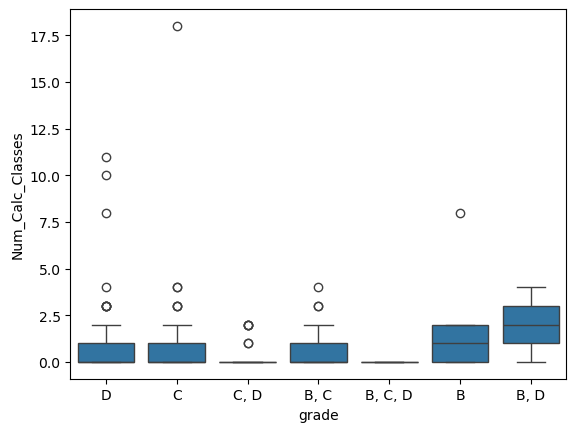

In [24]:
import seaborn as sns

sns.boxplot(data=df, x="grade", y="Num_Calc_Classes")
plt.title("Distribution of Calculus Class Counts by HOLC Grade")
plt.ylabel("Number of Calculus Classes")
plt.xlabel("HOLC Grade")
plt.show()


NameError: name 'plt' is not defined

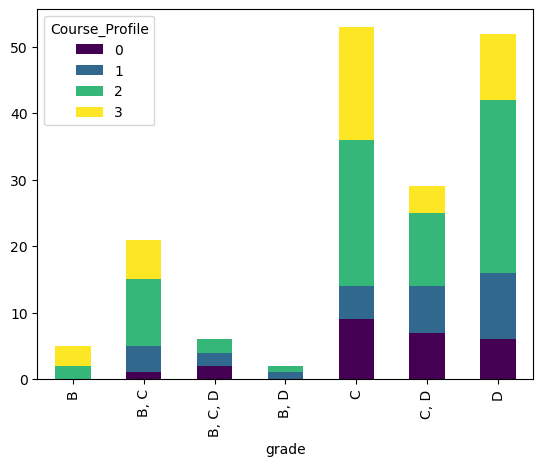

In [25]:
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

profile_counts.plot(kind="bar", stacked=True, colormap="viridis")
plt.ylabel("Number of Schools")
plt.title("Number of Advanced STEM Courses Offered per School, by HOLC Grade")
plt.show()


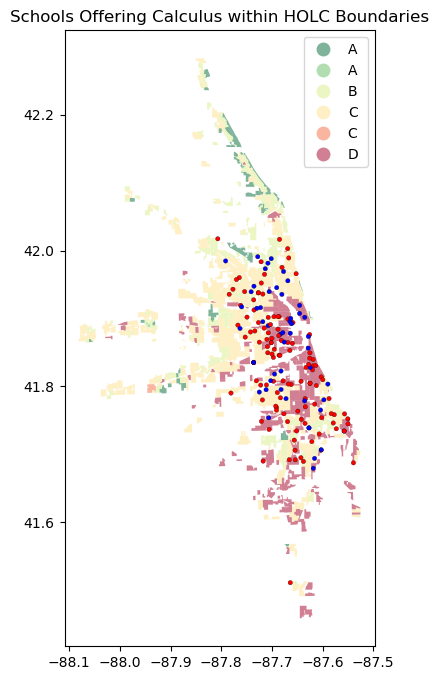

In [35]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# === 1. Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)  # match lat/lon coordinates

# === 2. Load your school CSV ===
schools_df = pd.read_csv("Calc_HS_Chicago.csv")

# === 3. Convert school CSV to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === 4. Plot ===
fig, ax = plt.subplots(figsize=(10, 8))
holc.plot(column="grade", cmap="RdYlGn_r", legend=True, alpha=0.5, ax=ax)
schools.plot(
    ax=ax,
    color=schools["Has_Calc"].map({"Yes": "blue", "No": "red"}),
    markersize=10,
    edgecolor="black",
    linewidth=0.2,
)
plt.title("Schools Offering Calculus within HOLC Boundaries")
plt.show()
